## Leaky integrated firing neuron model  
## Few feautures :
### Spatial network, no memory term but exponential decay of cumulative dose

This is a minor change of the Dodds and Watts model  
Implement adaptive rewiring and generate statistics

In [1]:
#importing the required libraries

import networkx as nx
import matplotlib.pyplot as plt #for plotting
import numpy as np #for using arrays and vectorising the code wherever possible
import scipy
import random
# from numba import jit #numba precomplier to make the code faster
import pandas as pd
import copy
import warnings
warnings.filterwarnings('ignore')

# Variables used in the simulation

In [2]:
N = 100
gamma = 1 #decay of cumulative dose per unit time (second)
T = 100 #total number of seconds
dt = 0.05 #seconds
'''number of simulation steps is T/dt'''

'''Dodds watts parameters'''
p = 1 #rate of dose transfer (per unit time (second))
p = p*dt #rate of dose transfer per unit simulation step
r = 1/dt
r = r*dt
rho = 1/dt
rho = rho*dt
# r = 0.5
# r = r*dt

d_star = 1
# dose_quantity = 1
D_ini = 3

'''network parameters'''
circ_rad = 100 #for a network in which each node is connected to other nodes withing a circle of radius circ_rad
nn = 7 #the number of nearest neighbours(i.e. k) in knn
average_degree = 6
total_edges = N*4

'''rewiring parameters'''
w_minus = 1
w_minus = w_minus*dt
# p_rew = 5 #rate of rewiring(per unit time(second))
# p_rew = p_rew*dt

# Creating the network. 
### The network outputs coordinates, distance matrix, edge_list and adjacency matrix

In [3]:
'''
obtains the number of nodes N
generates N points
calculates euclidean distance between each pair of points
returns the coordinates of the points and the distance matrix which is N*N
'''
def calc_dist(N) :
    coords = []
    for counter in range(N) :
        coords.append((N*np.random.random(),N*np.random.random()))

    dist_mat = scipy.spatial.distance.cdist(coords,coords)
    return dist_mat,coords

### 1. metric network

In [4]:
'''network = connect to points withing a circle of radius'''
#creates a link between points/nodes which satisfies the conditions of the network
def coupling(dist_mat,circ_rad) :
    edge_list = []
    edge_mask = (dist_mat<circ_rad) & (dist_mat>0)
    edge_list.extend(np.ndarray.tolist(np.transpose(np.where(edge_mask))))
#     print(type(np.ndarray.tolist(np.transpose(np.where(edge_mask)))))
    return edge_list

### 2. K nearest neighbour network

In [5]:
'''network = knn'''
def knn(dist_mat,nn,N) :
    near_neigh = np.argsort(dist_mat)
    selec_near_neigh = np.zeros((N,nn))
    selec_near_neigh = near_neigh[:,0:nn+1]

    edge_list = []
    for i in range(N) :
        for j in range(1,nn+1) :
            link = [i,selec_near_neigh[i,j]]
            edge_list.append(link)

    return edge_list

### 3. Random Network : GNP type

In [6]:
'''random network'''
def rand_network(average_degree,N) :
    z1 = np.random.uniform(size = (N,N))
    E,F = np.meshgrid(np.arange(0,N),np.arange(0,N))
    mask = ((average_degree/N) > z1) & (E!=F)
    adjacency_matrix = np.int64(np.zeros(shape=(N,N)))
    adjacency_matrix[mask] = np.int64(1)
    edge_list = []
    edge_list.extend(np.ndarray.tolist(np.transpose(np.where(adjacency_matrix==1))))
    return edge_list,adjacency_matrix

### 4. Random Network : GNM type

In [7]:
def rand_net_gnm(total_edges,N) :
    the_graph = nx.gnm_random_graph(N, total_edges,directed=True)
    adjacency_matrix = nx.adjacency_matrix(the_graph)
    adjacency_matrix = np.asarray(adjacency_matrix.todense())
    np.fill_diagonal(adjacency_matrix,0)
    edge_list = []
    edge_list.extend(np.ndarray.tolist(np.transpose(np.where(adjacency_matrix==1))))
    return edge_list

# Function defintions required for the main part of the script

In [8]:
# # @jit(nopython=True)
# '''infecting the left part of space.'''
# def left_part_infec(N) :
#     x_coord = []
#     y_coord = []
#     for j in range(len(coords)) :
#         x_coord.append(coords[j][0])
#         y_coord.append(coords[j][1])
#     x_coord = np.asarray(x_coord)
#     y_coord = np.asarray(y_coord)
#     points = np.asarray(np.where(x_coord<(N/5))) 
#     indi_state[points.T] = 2

#     return indi_state

In [9]:
'''infecting connected nodes'''
def InfectNetworkNeighbors(net,seed_node,init_infected_nodes):
     # if in bulk find one node randomly, and infect its neighbours
    infected_nodes = set()
    candidate_nodes = set()
    explored_nodes = set()

    #pick the seed node
    infected_nodes.add(seed_node)
    explored_nodes.add(seed_node)

    curr_node=seed_node

    #add its neighbors to the list of candidates
    for n in net.neighbors(curr_node):
        candidate_nodes.add(int(n))
    #print( curr_node)
    #print( candidate_nodes)

    #while we need to select more nodes...
    while len(infected_nodes) < init_infected_nodes:

        #if there are candidate nodes, select one of them
        if(len(candidate_nodes) > 0):
            new_node = np.random.choice(list(candidate_nodes),1)[0]
            infected_nodes.add(new_node)
            candidate_nodes.remove(new_node)

        elif len(infected_nodes - explored_nodes) > 0:
            curr_node = np.random.choice(list(infected_nodes -
            explored_nodes),1)[0]
            explored_nodes.add(curr_node)
            for n in set(net.neighbors(curr_node)) - infected_nodes:
                candidate_nodes.add(n)

        else:
#             print('Initial node infection step failed')
            return None
    return infected_nodes

In [10]:
''' function to transfer doses'''
# @jit(nopython=True)
def dose(adj_mat,p,partner_state_prev,d) :

    z1 = np.random.uniform(size=(len(adj_mat),len(adj_mat[0])))
    
    dose_transfer_mask = p > z1
    mod_adj_mat = np.multiply(adj_mat,z1) #modifying adjacency matrix to include the proability of dose transfer
    dose_mask = (p>mod_adj_mat) & (adj_mat!=0) & (partner_state_prev == 2)
    d[dose_mask] = dose_quantity #whenever it is proabable, dose transfer occurs
    
    return d

In [11]:
def rew(p_rew,adjacency_matrix,indi_state_for_rew_prev,OD_mesh2,lamb_da) :
    
    z1_rew_prew = np.random.uniform(size=(len(adj_mat),len(adj_mat[0])))
    z1_rew_lambda = np.random.uniform(size=(len(adj_mat),len(adj_mat[0])))
    
    rew_mask_plus = (p_rew > z1_rew_prew)  & (indi_state_for_rew_prev == 1)
    #create links. Dont break any.
    adjacency_matrix[rew_mask_plus] = 1
    rew_mask_minus1 = (w_minus > z1_rew_prew) & (indi_state_for_rew_prev == 2)
    #break links. Dont create any.
    adjacency_matrix[rew_mask_minus1] = 0
    rew_mask_minus2 = ((lamb_da*OD_mesh2) > z1_rew_lambda) & (indi_state_for_rew_prev == 1)
    adjacency_matrix[rew_mask_minus2] = 0
    
    np.fill_diagonal(adjacency_matrix,0)
    
    return adjacency_matrix

In [12]:
'''function to update cumulative doses'''
def cumu_dose(d,D_prev,gamma) :
    I = d.sum(axis=1).reshape(N,1)
#     I = 0
    D = (D_prev - (gamma*D_prev*dt)) + I
    return D

In [13]:
'''function to update the states of the nodes of the system'''
def upd_indi_state(D,d_star,indi_state_prev) :
    
    z2 = np.random.uniform(size=(N,1))
    z3 = np.random.uniform(size=(N,1))
    
    indi_state = indi_state_prev
    
    indi_state_mask1 = (D>=d_star) & (indi_state_prev==1)
    indi_state[indi_state_mask1] = 2
    
    indi_state_mask21 = (D<d_star) & (indi_state_prev==2) & (r>=z2) & (rho>=z3)
    indi_state[indi_state_mask21] = 1
    
    indi_state_mask22 = (D<d_star) & (indi_state_prev==2) & (r>=z2) & (rho<z3)
    indi_state[indi_state_mask22] = 3
    
    indi_state_mask23 = (D<d_star) & (indi_state_prev==2) & (r<z2)
    indi_state[indi_state_mask23] = 2
    
    return indi_state

In [14]:
'''function to get/identify the infected nodes and the suceptible nodes'''
def states(indi_state) :
    infec_indi = []
    suscep_indi = []
    infec_indi = np.transpose(np.where(indi_state==2))
    suscep_indi = np.transpose(np.where(indi_state==1))
    return infec_indi,suscep_indi

In [15]:
def networkx_graph(coords,edge_list) :
    G = nx.DiGraph()
    pos = {(i): (coords[i][0],coords[i][1]) for i in range(N)}
    G.add_nodes_from(pos.keys())
    G.add_edges_from(edge_list)
    return G

In [16]:
def edge_from_adj_mat(adj_mat_list,q):
    edge_list = []
    edge_list.extend(np.ndarray.tolist(np.transpose(np.where(adj_mat_list[q]==1))))
    return edge_list

# Choose which network you want in the program
### Coupling network of knn network?

In [17]:
# '''returns coordinates, distance matrix, edge_list and the adjacency matrix'''

# dist_mat,coords = calc_dist(N) #node placement

# # edge_list = coupling(dist_mat,circ_rad)
# # edge_list = knn(dist_mat,nn,N)
# # edge_list = rand_network(average_degree,N)
# edge_list = rand_net_gnm(total_edges,N)

# org_adj_mat = np.int64(np.zeros((N,N)))
# for i in range(len(edge_list)):
#     org_adj_mat[edge_list[i][0],edge_list[i][1]] = np.int64(1)

# The main part of the script

In [18]:
#infected state time series data frame
#columns indicate the time steps
timeseries_infec_frac = pd.DataFrame()

#in degree as columns and rows as nodes
timeseries_in_degree = pd.DataFrame() 

#out degree as columns and rows as nodes
timeseries_out_degree = pd.DataFrame()

#strongly connected components as columns
timeseries_connec_comps = pd.DataFrame()

In [19]:
p_rew_vals = [0.01,0.1,1,10]
start_vals = [1,10]
dose_quantity_vals = [0.5,2]

In [20]:
for sim in range(70,70+25) :
    '''returns coordinates, distance matrix, edge_list and the adjacency matrix'''
    dist_mat,coords = calc_dist(N) #node placement
    edge_list = rand_net_gnm(total_edges,N)
    org_adj_mat = np.int64(np.zeros((N,N)))
    for i in range(len(edge_list)):
        org_adj_mat[edge_list[i][0],edge_list[i][1]] = np.int64(1)
        
    df_row = 0
    for p_rew in p_rew_vals : #rate of rewiring (per unit time (second))
        lamb_da = p_rew/10
        lamb_da = lamb_da*dt
        p_rew = p_rew*dt
        for start in start_vals : #rate of dose transfer (per unit time (second))
            for dose_quantity in dose_quantity_vals : #number of nodes to infect initially
                print('(sim,lamb_da,p_rew,w_minus,start,dose_quantity) = ', (sim,lamb_da/dt,p_rew/dt,w_minus/dt,start,dose_quantity))

                '''clearing exsiting data frames and creating new ones '''
                timeseries_infec_frac = pd.DataFrame()
                timeseries_in_degree = pd.DataFrame()
                timeseries_out_degree = pd.DataFrame()
                timeseries_connec_comps = pd.DataFrame()

                q = 0 #to generate new edge_list from the new adjacency matrix 
                t = np.arange(0,T,dt)

    #             numpy_array = np.zeros((N,len(t)),dtype = np.int64) #stores the states of the nodes. Rows are nodes and columns are time steps
                D_array = np.zeros((N,len(t))) #stores the cumulative doses. Rows are nodes and columns are time steps

                adj_mat_list = []
                adj_mat = copy.deepcopy(org_adj_mat)
                adj_mat_new = copy.deepcopy(adj_mat)
                adj_mat_list.append(adj_mat_new) #list of arrays which shows the time series of the adjacency matrix

                #coords remain the same. Get new edge_list from the latest adjacency matrix
                edge_list = edge_from_adj_mat(adj_mat_list,q)
                G = networkx_graph(coords,edge_list) #networkx graph

                '''from G, obtain the in degree and the out degree'''
                timeseries_in_degree.loc[:,0] = np.asarray([val for (node, val) in G.in_degree()])
                timeseries_out_degree.loc[:,0] = np.asarray([val for (node, val) in G.out_degree()])

                '''strongly and weekely connected components'''
                timeseries_connec_comps.loc[0,0] = nx.number_connected_components(G.to_undirected())

                '''choosing initially infected nodes'''
                indi_state = np.random.randint(1,2,size=(N,1))
                infected_nodes = None
                while infected_nodes is None : #infecting 'start' number of network neighbours
                    infected_nodes = InfectNetworkNeighbors(G,np.random.randint(N),start)
                print(infected_nodes)
                infected_nodes = np.asarray(list(infected_nodes)).reshape(len(infected_nodes),1)
                indi_state[infected_nodes[:,0],0] = 2

                A,B = np.meshgrid(indi_state,indi_state) 
                partner_state = A
                indi_state_for_rew = B

    #             numpy_array [:,0] = indi_state[:,0]

                indi_state_prev = indi_state
                partner_state_prev = partner_state
                indi_state_for_rew_prev = indi_state_for_rew

                d = np.zeros((len(adj_mat),len(adj_mat[0])))

                D = np.zeros((N,1))
                D[np.where(indi_state==2)] = D_ini
                D_array[:,0] = D[:,0]
                D_prev = D

                infec_frac = np.count_nonzero(indi_state == 2)/N
                timeseries_infec_frac.loc[df_row,0] = infec_frac
                '''the main part of the simulation'''
                counter = 0
                df_col = 1
                for t in np.arange(dt,T,dt) :
                    q = q + 1 
                    counter = counter + 1
                    infec_indi = []
                    suscep_indi = []
                    d = np.zeros((len(adj_mat),len(adj_mat[0])))
                    d = dose(adj_mat,p,partner_state_prev,d)

                    OD_array = np.asarray([val for (node, val) in G.out_degree()])
                    OD_mesh1,OD_mesh2 = np.meshgrid(OD_array,OD_array)
                    adj_mat = rew(p_rew,adj_mat,indi_state_for_rew_prev,OD_mesh2,lamb_da)
                    adj_mat_new = copy.deepcopy(adj_mat)
                    adj_mat_list.append(adj_mat_new)

                    #coords remain the same. Get new edge_list from the latest adjacency matrix
                    edge_list = edge_from_adj_mat(adj_mat_list,q)
                    G = networkx_graph(coords,edge_list) #networkx graph

                    '''from G, obtain the in degree and the out degree'''
                    timeseries_in_degree.loc[:,df_col] = np.asarray([val for (node, val) in G.in_degree()])
                    timeseries_out_degree.loc[:,df_col] = np.asarray([val for (node, val) in G.out_degree()])

                    '''strongly and weekely connected components'''
                    timeseries_connec_comps.loc[df_row,df_col] = nx.number_connected_components(G.to_undirected())

                    D = cumu_dose(d,D_prev,gamma)
                    D_array[:,counter] = D[:,0]

                    indi_state = upd_indi_state(D,d_star,indi_state_prev)
                    infec_frac = np.count_nonzero(indi_state == 2)/N
                    timeseries_infec_frac.loc[df_row,df_col] = infec_frac

    #                 numpy_array[:,counter] = indi_state[:,0]
                    A,B = np.meshgrid(indi_state,indi_state)

                    infec_indi, suscep_indi = states(indi_state)

                    partner_state = A
                    indi_state_for_rew = B
                    indi_state_prev = indi_state
                    partner_state_prev = partner_state
                    indi_state_for_rew_prev = indi_state_for_rew

                    D_prev = D
                    D = np.zeros((N,1))
                    df_col = df_col + 1 

    #             df_row = df_row + 1 #going to the next row of the df to store timeseries of next (p,start)

                filename_infec_frac = 'infec_frac.h5'
                filename_in_deg = 'in_deg.h5'
                filename_out_deg = 'out_deg.h5'
                filename_connec_comps = 'connec_comps.h5'
                p_rew_val = '%g'%(p_rew/dt)
                key_val = 'sim_'+str(sim)+'_p_rew_'+str(p_rew_val)+'_start_'+str(start)+'_dq_'+str(dose_quantity)
                print(key_val)
                timeseries_infec_frac.to_hdf(filename_infec_frac, key = key_val, mode='a')
                timeseries_in_degree.to_hdf(filename_in_deg, key = key_val, mode='a')
                timeseries_out_degree.to_hdf(filename_out_deg, key = key_val, mode='a')
                timeseries_connec_comps.to_hdf(filename_connec_comps, key = key_val, mode='a')
                df_row = 0

(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (70, 0.001, 0.01, 1.0, 1, 0.5)
{54}
sim_70_p_rew_0.01_start_1_dq_0.5
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (70, 0.001, 0.01, 1.0, 1, 2)
{88}
sim_70_p_rew_0.01_start_1_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (70, 0.001, 0.01, 1.0, 10, 0.5)
{34, 68, 70, 42, 92, 16, 87, 60, 93, 31}
sim_70_p_rew_0.01_start_10_dq_0.5
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (70, 0.001, 0.01, 1.0, 10, 2)
{97, 6, 38, 41, 49, 82, 22, 28, 61, 30}
sim_70_p_rew_0.01_start_10_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (70, 0.01, 0.10000000000000002, 1.0, 1, 0.5)
{63}
sim_70_p_rew_0.1_start_1_dq_0.5
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (70, 0.01, 0.10000000000000002, 1.0, 1, 2)
{61}
sim_70_p_rew_0.1_start_1_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (70, 0.01, 0.10000000000000002, 1.0, 10, 0.5)
{2, 8, 78, 47, 79, 49, 52, 23, 25, 90}
sim_70_p_rew_0.1_start_10_dq_0.5
(sim,lamb_da,p_rew,w_m

sim_73_p_rew_1_start_10_dq_0.5
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (73, 0.10000000000000002, 1.0, 1.0, 10, 2)
{98, 3, 37, 39, 73, 13, 46, 48, 22, 31}
sim_73_p_rew_1_start_10_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (73, 1.0, 10.0, 1.0, 1, 0.5)
{25}
sim_73_p_rew_10_start_1_dq_0.5
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (73, 1.0, 10.0, 1.0, 1, 2)
{11}
sim_73_p_rew_10_start_1_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (73, 1.0, 10.0, 1.0, 10, 0.5)
{96, 98, 4, 5, 38, 71, 41, 42, 22, 94}
sim_73_p_rew_10_start_10_dq_0.5
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (73, 1.0, 10.0, 1.0, 10, 2)
{64, 0, 99, 43, 77, 78, 16, 88, 25, 59}
sim_73_p_rew_10_start_10_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (74, 0.001, 0.01, 1.0, 1, 0.5)
{4}
sim_74_p_rew_0.01_start_1_dq_0.5
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (74, 0.001, 0.01, 1.0, 1, 2)
{89}
sim_74_p_rew_0.01_start_1_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quan

sim_77_p_rew_0.1_start_1_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (77, 0.01, 0.10000000000000002, 1.0, 10, 0.5)
{97, 98, 5, 71, 50, 18, 55, 57, 27, 63}
sim_77_p_rew_0.1_start_10_dq_0.5
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (77, 0.01, 0.10000000000000002, 1.0, 10, 2)
{4, 6, 71, 46, 48, 16, 23, 56, 94, 95}
sim_77_p_rew_0.1_start_10_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (77, 0.10000000000000002, 1.0, 1.0, 1, 0.5)
{98}
sim_77_p_rew_1_start_1_dq_0.5
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (77, 0.10000000000000002, 1.0, 1.0, 1, 2)
{4}
sim_77_p_rew_1_start_1_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (77, 0.10000000000000002, 1.0, 1.0, 10, 0.5)
{1, 67, 99, 49, 81, 84, 22, 56, 88, 62}
sim_77_p_rew_1_start_10_dq_0.5
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (77, 0.10000000000000002, 1.0, 1.0, 10, 2)
{32, 65, 34, 70, 76, 79, 17, 82, 85, 93}
sim_77_p_rew_1_start_10_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =

sim_80_p_rew_10_start_10_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (81, 0.001, 0.01, 1.0, 1, 0.5)
{5}
sim_81_p_rew_0.01_start_1_dq_0.5
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (81, 0.001, 0.01, 1.0, 1, 2)
{23}
sim_81_p_rew_0.01_start_1_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (81, 0.001, 0.01, 1.0, 10, 0.5)
{33, 12, 45, 52, 85, 24, 88, 93, 62, 31}
sim_81_p_rew_0.01_start_10_dq_0.5
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (81, 0.001, 0.01, 1.0, 10, 2)
{98, 3, 7, 8, 71, 74, 14, 49, 88, 58}
sim_81_p_rew_0.01_start_10_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (81, 0.01, 0.10000000000000002, 1.0, 1, 0.5)
{30}
sim_81_p_rew_0.1_start_1_dq_0.5
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (81, 0.01, 0.10000000000000002, 1.0, 1, 2)
{14}
sim_81_p_rew_0.1_start_1_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (81, 0.01, 0.10000000000000002, 1.0, 10, 0.5)
{37, 75, 18, 83, 50, 21, 55, 25, 92, 30}
sim_81_p_rew_0.1_start_10_

(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (84, 0.10000000000000002, 1.0, 1.0, 10, 0.5)
{1, 3, 4, 69, 6, 71, 14, 54, 91, 61}
sim_84_p_rew_1_start_10_dq_0.5
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (84, 0.10000000000000002, 1.0, 1.0, 10, 2)
{0, 98, 35, 71, 10, 75, 44, 12, 15, 89}
sim_84_p_rew_1_start_10_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (84, 1.0, 10.0, 1.0, 1, 0.5)
{41}
sim_84_p_rew_10_start_1_dq_0.5
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (84, 1.0, 10.0, 1.0, 1, 2)
{2}
sim_84_p_rew_10_start_1_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (84, 1.0, 10.0, 1.0, 10, 0.5)
{65, 36, 8, 14, 46, 81, 85, 55, 87, 60}
sim_84_p_rew_10_start_10_dq_0.5
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (84, 1.0, 10.0, 1.0, 10, 2)
{33, 66, 37, 69, 42, 76, 13, 51, 59, 60}
sim_84_p_rew_10_start_10_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (85, 0.001, 0.01, 1.0, 1, 0.5)
{41}
sim_85_p_rew_0.01_start_1_dq_0.5
(sim,lamb_da,p_rew,w_mi

sim_88_p_rew_0.1_start_1_dq_0.5
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (88, 0.01, 0.10000000000000002, 1.0, 1, 2)
{91}
sim_88_p_rew_0.1_start_1_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (88, 0.01, 0.10000000000000002, 1.0, 10, 0.5)
{66, 99, 4, 42, 11, 46, 81, 50, 89, 61}
sim_88_p_rew_0.1_start_10_dq_0.5
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (88, 0.01, 0.10000000000000002, 1.0, 10, 2)
{0, 2, 9, 44, 78, 49, 53, 57, 27, 93}
sim_88_p_rew_0.1_start_10_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (88, 0.10000000000000002, 1.0, 1.0, 1, 0.5)
{76}
sim_88_p_rew_1_start_1_dq_0.5
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (88, 0.10000000000000002, 1.0, 1.0, 1, 2)
{34}
sim_88_p_rew_1_start_1_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (88, 0.10000000000000002, 1.0, 1.0, 10, 0.5)
{97, 34, 7, 71, 44, 45, 15, 50, 20, 31}
sim_88_p_rew_1_start_10_dq_0.5
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (88, 0.10000000000000002, 1.0, 

sim_91_p_rew_10_start_10_dq_0.5
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (91, 1.0, 10.0, 1.0, 10, 2)
{1, 34, 46, 78, 47, 49, 83, 22, 60, 95}
sim_91_p_rew_10_start_10_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (92, 0.001, 0.01, 1.0, 1, 0.5)
{27}
sim_92_p_rew_0.01_start_1_dq_0.5
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (92, 0.001, 0.01, 1.0, 1, 2)
{73}
sim_92_p_rew_0.01_start_1_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (92, 0.001, 0.01, 1.0, 10, 0.5)
{96, 41, 43, 31, 78, 88, 59, 60, 62, 63}
sim_92_p_rew_0.01_start_10_dq_0.5
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (92, 0.001, 0.01, 1.0, 10, 2)
{32, 68, 4, 8, 45, 16, 48, 51, 20, 28}
sim_92_p_rew_0.01_start_10_dq_2
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (92, 0.01, 0.10000000000000002, 1.0, 1, 0.5)
{43}
sim_92_p_rew_0.1_start_1_dq_0.5
(sim,lamb_da,p_rew,w_minus,start,dose_quantity) =  (92, 0.01, 0.10000000000000002, 1.0, 1, 2)
{58}
sim_92_p_rew_0.1_start_1_dq_2
(sim,lamb_d

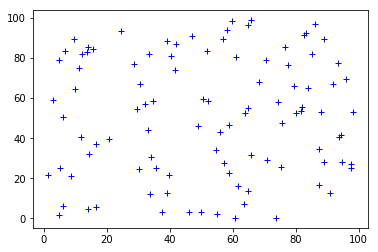

In [21]:
for i in range(len(coords)) :
    plt.plot(coords[i][0],coords[i][1],'b+')

In [22]:
edge_list

[[19, 0],
 [19, 1],
 [19, 3],
 [19, 4],
 [19, 9],
 [19, 10],
 [19, 11],
 [19, 12],
 [19, 14],
 [19, 17],
 [19, 21],
 [19, 24],
 [19, 26],
 [19, 28],
 [19, 29],
 [19, 30],
 [19, 31],
 [19, 32],
 [19, 34],
 [19, 35],
 [19, 36],
 [19, 37],
 [19, 38],
 [19, 41],
 [19, 43],
 [19, 45],
 [19, 47],
 [19, 49],
 [19, 51],
 [19, 57],
 [19, 59],
 [19, 61],
 [19, 62],
 [19, 65],
 [19, 67],
 [19, 72],
 [19, 75],
 [19, 80],
 [19, 81],
 [19, 84],
 [19, 85],
 [19, 89],
 [19, 90],
 [19, 91],
 [19, 94],
 [19, 98],
 [80, 0],
 [80, 2],
 [80, 3],
 [80, 6],
 [80, 12],
 [80, 14],
 [80, 16],
 [80, 19],
 [80, 23],
 [80, 24],
 [80, 25],
 [80, 27],
 [80, 30],
 [80, 33],
 [80, 34],
 [80, 35],
 [80, 36],
 [80, 40],
 [80, 41],
 [80, 42],
 [80, 44],
 [80, 49],
 [80, 51],
 [80, 53],
 [80, 54],
 [80, 57],
 [80, 58],
 [80, 59],
 [80, 60],
 [80, 61],
 [80, 64],
 [80, 66],
 [80, 67],
 [80, 73],
 [80, 74],
 [80, 75],
 [80, 78],
 [80, 82],
 [80, 86],
 [80, 89],
 [80, 90],
 [80, 91],
 [80, 92],
 [80, 94],
 [80, 98],
 [80, 99